#### Guillaume Capitan, Baptiste Moalic - TSIA206 2022 

# Dynamic Time Warping for Speech Recognition
Chloé Clavel / Matthieu Labeau (original lab by Olivier Cappé)

In [1]:
import os
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
import IPython
import seaborn as sns

## Data

The directory ```DATA``` contains three directories :
- ```SIG``` contains 12 repetitions of numbers from 0 to 9 by speaker1 (F e = 8000kHz). SIG_Rep_5_Number_3.wav is the recording corresponding to the fifth repetition of the number “3” . The first four repetitions of each number are represented on Figure 1.
- ```SIG2```, contains 6 repetitions of numbers from 0 to 9 by speaker2
- ```SIG_MIXED``` contains 6 repetitions of the number by speaker1 (SIG_MIXED_Rep_1:6) and then by speaker2 ( SIG_MIXED_Rep_7:12).

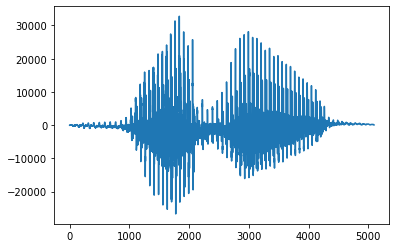

In [2]:
from scipy.io import wavfile

file_path = "./SIG/SIG_Rep_1_Number_0.wav"
sample_rate, wav_data = wavfile.read(file_path)
plt.plot(wav_data)
plt.show()

In [3]:
IPython.display.Audio(file_path)

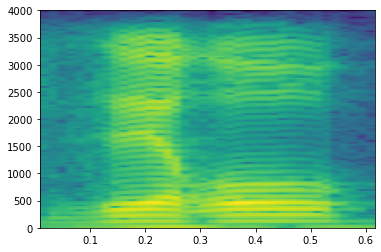

In [4]:
plt.specgram(wav_data, Fs=sample_rate)
plt.show()

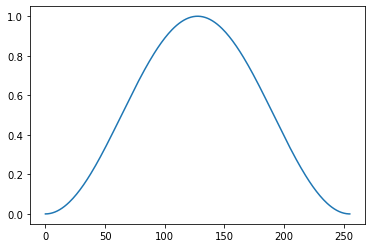

In [5]:
plt.plot(np.hanning(256))

## Speech Feature Extraction

Write a python function ```feature_extraction``` to calculate the cepstral parameterization associated with each pronunciation. With regard to the parameters of the analysis, we will make the following choices: 
- **Parameterization type**: Cepstrum (real number) using linear frequency scale (as opposed to Mel-frequency cepstrum) and computed using FFT (Fast Fourier Transform)
- **Weigthing window**: Hanning

The inputs of the function will be the following:
- **Wav data**: The data extracted from a .wav file
- **Window size**: 256 samples (32 ms)
- **Window shift**: 128 samples
- **Cepstral order**: p = 10


For each signal, the result of the analysis is a sequence of parameters that will be stored in a matrix
according to the following convention:

$$ \quad X = \underbrace{\left[\begin{array}{c} 
 X_1 \\
 X_2 \\
 \vdots \\
 X_{l_X}
\end{array} \right]}_p  $$

Each $X_i$ is a line vector of size $p$. Note that the number of ceptral vectors obtained ($l_X$) depends on the length of the signal, so it is variable. We obtain one matrix of this type per signal.

In [6]:
def feature_extraction(wav_data, window_size, window_shift, cepstral_order):
    #
    # Indication: use the numpy functions np.hanning, np.fft.fft, and np.fft.ifft.
    # Use the attribute .real to take the real part of complex numbers that are output by np.fft.ifft
    # Don't hesitate to look at the numpy documentation to get a better understanding of what the functions do !
    length = np.size(wav_data)
    
    #Determination of how many windows we can extract from the signal
    L_f = length//window_shift
    window = np.hanning(window_size)
    
    #Initialization of cepstral_vectors
    cepstral_vectors = np.zeros((L_f-1, cepstral_order))
    
    for k in range(L_f-1):
        x = wav_data[(k*window_shift) : (k*window_shift+window_size)]
        x_w = np.multiply(x, window) #smoothed signal
        
        spectrum = np.fft.fft(x_w) 
        #print('spectrum = '+str(spectrum))
        log_spectrum = np.log(abs(spectrum))
        #print('log_spectrum = '+str(log_spectrum))
        cepstrum = np.fft.ifft(log_spectrum)
        #print('cepstrum = '+str(cepstrum))
        cepstrum_real = cepstrum.real #we are only interested in the real part
        #print('cepstrum_real = '+str(cepstrum_real))
        cepstral_vector = cepstrum_real[:cepstral_order] #and the 10 first terms
        #print('cepstral_vector = '+str(cepstral_vector))
        
        cepstral_vectors[k,:] = cepstral_vector

    return cepstral_vectors

In [7]:
# Example !
window_size = 256
window_shift = 128
cepstral_order = 10
cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)

In [8]:
print("Shape of cepstral matrix:", [len(cepstral_vectors), len(cepstral_vectors[0])])

Shape of cepstral matrix: [38, 10]


## Time Alignment by Dynamic Programming

Write a python function ```time_alignment(x, y, gamma)``` performing time alignment by dynamic programming between two sequences of vectors stored with the convention above. The Euclidean norm between the following vectors and time
constraints will be used:

\begin{matrix}
  \bullet & \rightarrow & \bullet\\
   & \nearrow_{\gamma} & \uparrow\\
  \bullet & & \bullet
\end{matrix}

with a diagonal weighting $\gamma$ that may be chosen different from 1. It is essential to carry out this function in a parameterized way in order to be able to validate it on the mono-dimensional example being studied.
The function will take as **inputs** the two vector sequences $(X_1, \dots, X_{l_X})$ et $(Y_1, \dots, Y_{l_Y})$ stored in the two matrices, as well as the parameter $\gamma$. It will then execute the following operations:
- **Calculation of the similarity matrix**: Given the two vector sequences, calculate the matrix $D (l_X \times l_Y)$ such that $D(i,j) = \|X_i-Y_j\|$.
- **Initialization of the cumulative distance matrix**: Calculate the content of the first row and column of the cumulative distance matrix $C (l_X \times l_Y)$ such that $C(i,j)$ contains the cumulative distance along the minimum cumulative distance path joining the node $(i,j)$ at the initial node $(1,1)$.
- **Calculation of the matrix of cumulative distances**: For $i$ ranging from 2 to $\min(l_X,l_Y)$, calculation of $C(i,i)$ then $C(i+1,i), \dots C(l_X,i)$ and $C(i,i+1), C(i,i+2), \dots C(i,l_Y)$ (you will recall what justifies this way to proceed). To store the predecessor along the optimal path leading to $(i,j)$, you can use a three-dimensional array $B (l_X \times l_Y \times 2)$ since the predecessor is a node of the network defined by its two coordinates (we can alternatively use a "code" representing the three possible predecessors).
- ***Bactracking***: From the node $(l_X,l_Y)$, reconstruction of the optimal path (starting from the end).

Finally, the **output** will be the cumulative distance along the path of least cost  (```distance```) and the alignment path (```M```), in the form of the matrix  $M$  with two columns such that $X_{M(i,1)}$  is the vector mapped to $Y_{M(i,2)}$ (note that the number of lines in this matrix corresponding to the length of the optimal path is variable). The function can also return the matrix of cumulative distances (```C```).

In [9]:
from scipy.spatial.distance import cdist

def time_alignment(x, y, gamma):
    len_x = x.shape[0]
    len_y = y.shape[0]
    
    #Calculation of the similarity matrix
    D = cdist(x, y, 'euclidean')
    
    #Initialization of the cumulative distance matrix
    C_first_column = np.zeros(len_x)
    for k in range(len_x):
        C_first_column[k] = np.sum(D[:k, 0])

    C_first_row = np.zeros(len_y)
    for k in range(len_y):
        C_first_row[k] = np.sum(D[0, :k])
    
    C = np.zeros((len_x, len_y))
    C[:, 0] = C_first_column
    C[0, :] = C_first_row
    
    #Calculation of the matrix of cumulative distances
    #Initialization of the predecessors matrix
    B = np.zeros((len_x, len_y, 3))
    
    #Start of the loop
    for i in range(1, min(len_x, len_y)):
        
        """
        Let's set a convention for the predecessors:
        Coming from i-1 ==> first element of the array
        Coming from j-1 ==> second element of the array
        Coming from the diagonal i-1,j-1 ==> third element of the array
        """
        
        #Calculation of C[i,i]
        dist = np.array([C[i-1, i]+D[i, i], C[i, i-1]+D[i, i], C[i-1, i-1]+gamma*D[i, i]]) #Computing all distances possible
        C[i, i] = np.amin(dist) #Keeping the minimal one
        predecessor = np.argmin(dist) #From which side do we come from?
        if(predecessor==0):
            B[i, i, :] = np.array([i-1, i, 1]) #Side
        elif(predecessor==1):
            B[i, i, :] = np.array([i, i-1, 1]) #Top
        else:
            B[i, i, :] = np.array([i-1, i-1, gamma]) #Diagonal
            
        #Calculating along the side
        for l in range(i+1, len_x):
            dist = np.array([C[l-1, i]+D[l, i], C[l, i-1]+D[l, i], C[l-1, i-1]+gamma*D[l, i]]) #Computing all distances possible
            C[l, i] = np.amin(dist) #Keeping the minimal one
            predecessor = np.argmin(dist) #From which side do we come from?
            if(predecessor==0):
                B[l, i, :] = np.array([l-1, i, 1]) #Side
            elif(predecessor==1):
                B[l, i, :] = np.array([l, i-1, 1]) #Top
            else:
                B[l, i, :] = np.array([l-1, i-1, gamma]) #Diagonal
                
        #Calculating along the top
        for m in range(i+1, len_y):
            dist = np.array([C[i, m-1]+D[i, m], C[i-1, m]+D[i, m], C[i-1, m-1]+gamma*D[i, m]]) #Computing all distances possible
            C[i, m] = np.amin(dist) #Keeping the minimal one
            predecessor = np.argmin(dist) #From which side do we come from?
            if(predecessor==0):
                B[i, m, :] = np.array([i, m-1, 1]) #Side
            elif(predecessor==1):
                B[i, m, :] = np.array([i-1, m, 1]) #Top
            else:
                B[i, m, :] = np.array([i-1, m-1, gamma]) #Diagonal
                
    B = B.astype(np.int32) #B was by deafault initialized with float types, we revert it to integers so we can iterate over them after

    #Initialization of the alignment path matrix
    M = np.array([len_x-1, len_y-1]) #We add manually the first term
    pred_to_add = B[-1, -1, :]
    normalization = 0
    while(not(np.array_equal(pred_to_add[:2], np.array([0, 0])))):
        M = np.append(M, pred_to_add[:2])
        normalization += pred_to_add[2]
        pred_to_add = B[pred_to_add[0], pred_to_add[1], :]

    #[0,0] makes us exit the loop, but we have to take into account this last iteration for the normalization
    M = np.append(M, np.array([0, 0]))
    M = np.reshape(M, (-1, 2)) #When we added the tuples, we only had a long list, we reshape to retrieve the coordinates format
    M = np.flip(M) #We want to start by the [0,0] case
    if(np.array_equal(M[1, :], np.array([1, 1]))):
        normalization += gamma #If we come from [1, 1], it means we've taken the diagonal => normalization += gamma
    else:
        normalization += 1 #Otherwise, we come from a side => normalization += 1
       
    distance = C[-1, -1]/normalization

    return C, M, distance

In [10]:
# Example of time alignment
file_path_1 = "./SIG/SIG_Rep_1_Number_0.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
file_path_2 = "./SIG/SIG_Rep_2_Number_0.wav"
sample_rate_2, wav_data_2 = wavfile.read(file_path_2)
cepstral_vectors_1 = feature_extraction(
wav_data_1, window_size, window_shift, cepstral_order)
cepstral_vectors_2 = feature_extraction(
wav_data_2, window_size, window_shift, cepstral_order)

np.set_printoptions(precision=4)
C, M, distance = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=2)

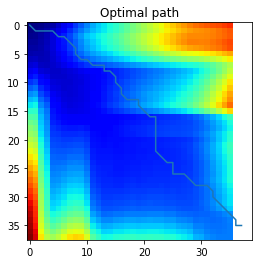

Cost of the optimal path: 0.3281745715530288


In [11]:
# Example of visualization of the optimal path
M = np.array(M)
plt.imshow(C, cmap='jet')
plt.title("Optimal path")
plt.plot(M[:,1], M[:,0])
plt.show()
print("Cost of the optimal path:", distance)

## Applications to Speech Data

First, working on the data from ```SIG```, you will align a reference sequence (for example, the one corresponding to the first repetition of the first word) with all the others. If we try to find, among all numbers of a given repetition (from 1 to 12), which is the same one as the reference, by looking at the closest in terms of distance (of the path of least cost):
1. Are the performances satisfactory ?
2. What is the influence of the γ choice (weighting of the diagonal path) on the alignment paths (in order to answer, examine characteristic cases and try to judge the relevance of the alignment paths by visualizing them) ? Does this parameter have a significant influence on the obtained distance?
3. What implicit hypothesis is made when using the Euclidean distance to measure the proximity of ceptral vectors? Does this hypothesis seem acceptable to you in view of the differences between aligned sequences corresponding to different repetitions of the same word? Propose (it is not necessary to implement it!) a method to estimate from the aligned data an appropriate weighting for the comparison of ceptral vectors. Do you think this weighting could improve discrimination performance?

In [12]:
#Global parameters
window_size = 256
window_shift = 128
cepstral_order = 10

In [13]:
#Reference:
file_path_ref = "./SIG/SIG_Rep_1_Number_6.wav"
sample_rate_ref, wav_data_ref = wavfile.read(file_path_ref)
cepstral_vectors_ref = feature_extraction(wav_data_ref, window_size, window_shift, cepstral_order)
name_ref = 'Rep 1 Nb 6'

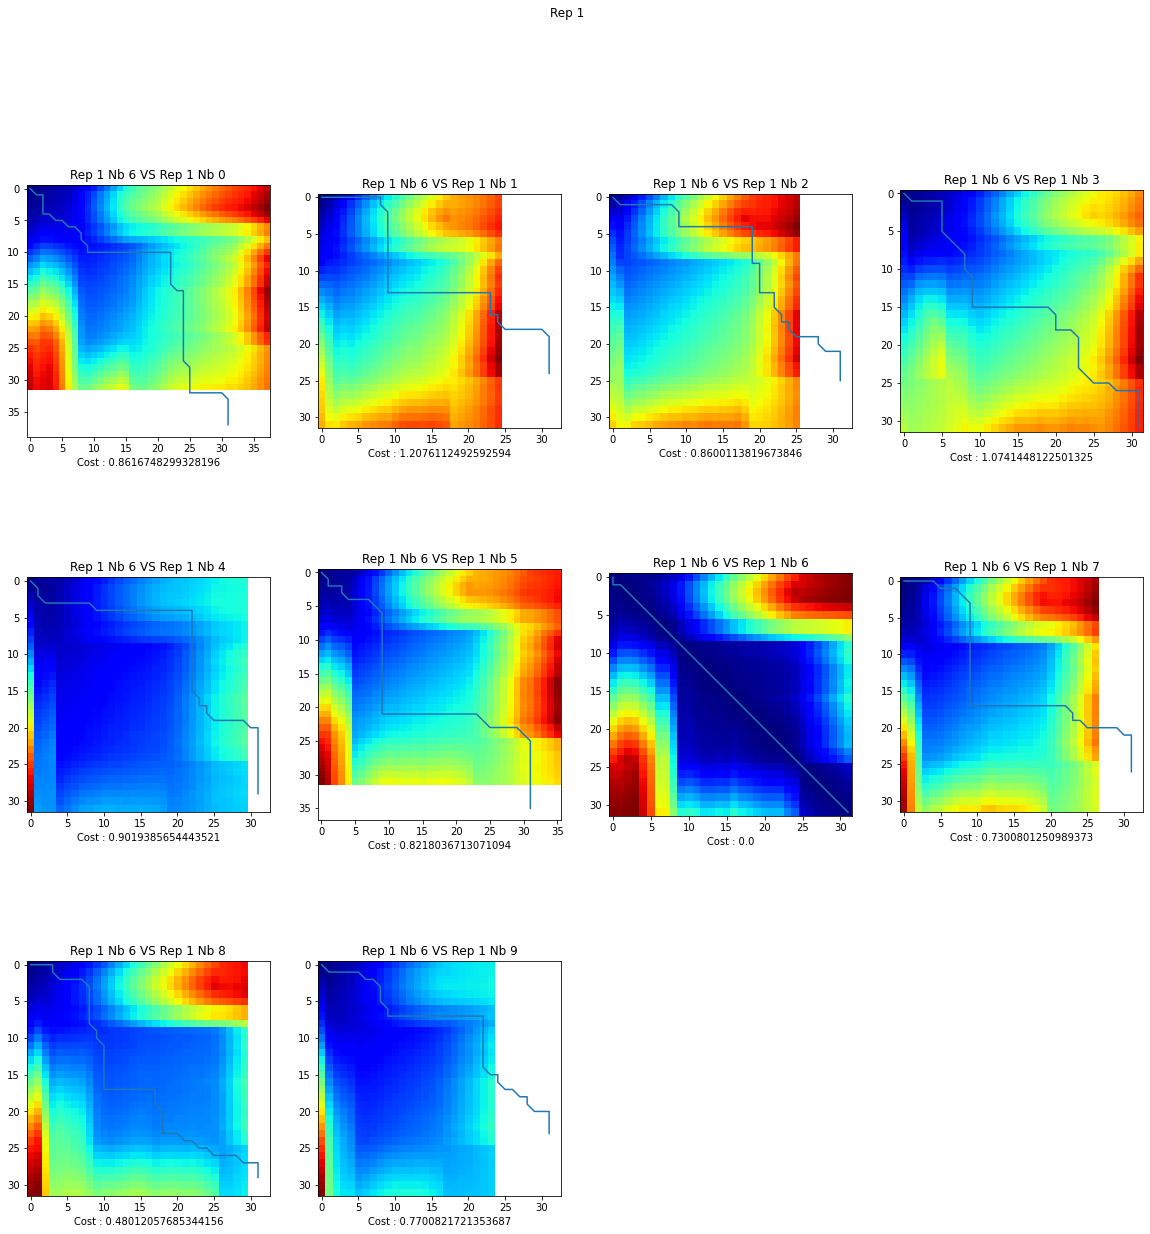

The closest distance to the reference sequence is 0.0 achieved by the number 6


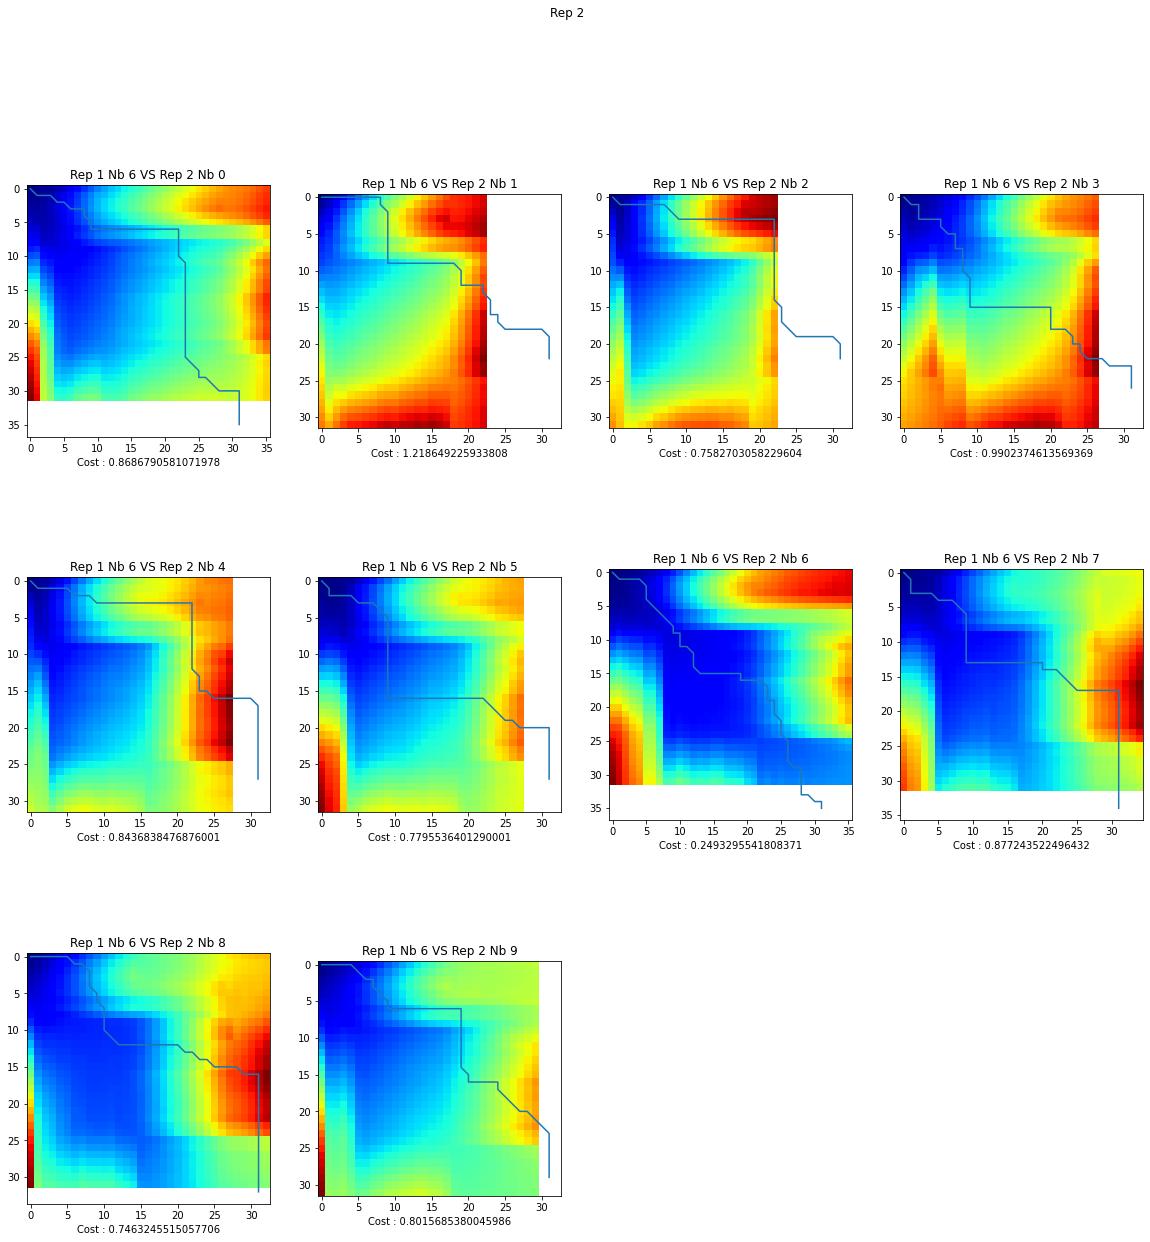

The closest distance to the reference sequence is 0.2493295541808371 achieved by the number 6


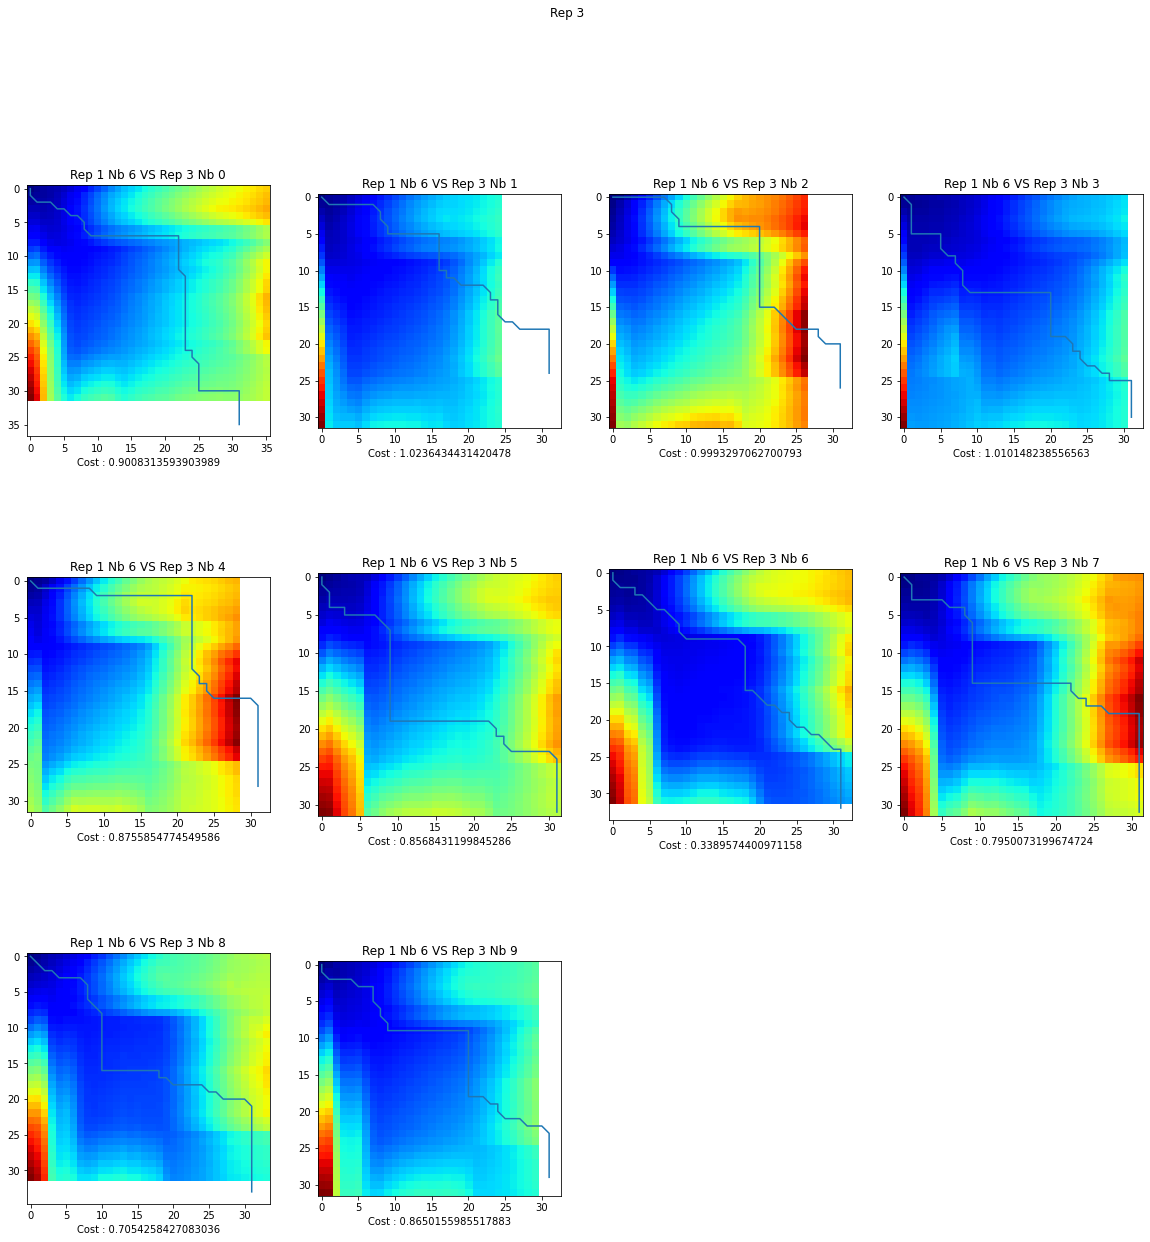

The closest distance to the reference sequence is 0.3389574400971158 achieved by the number 6


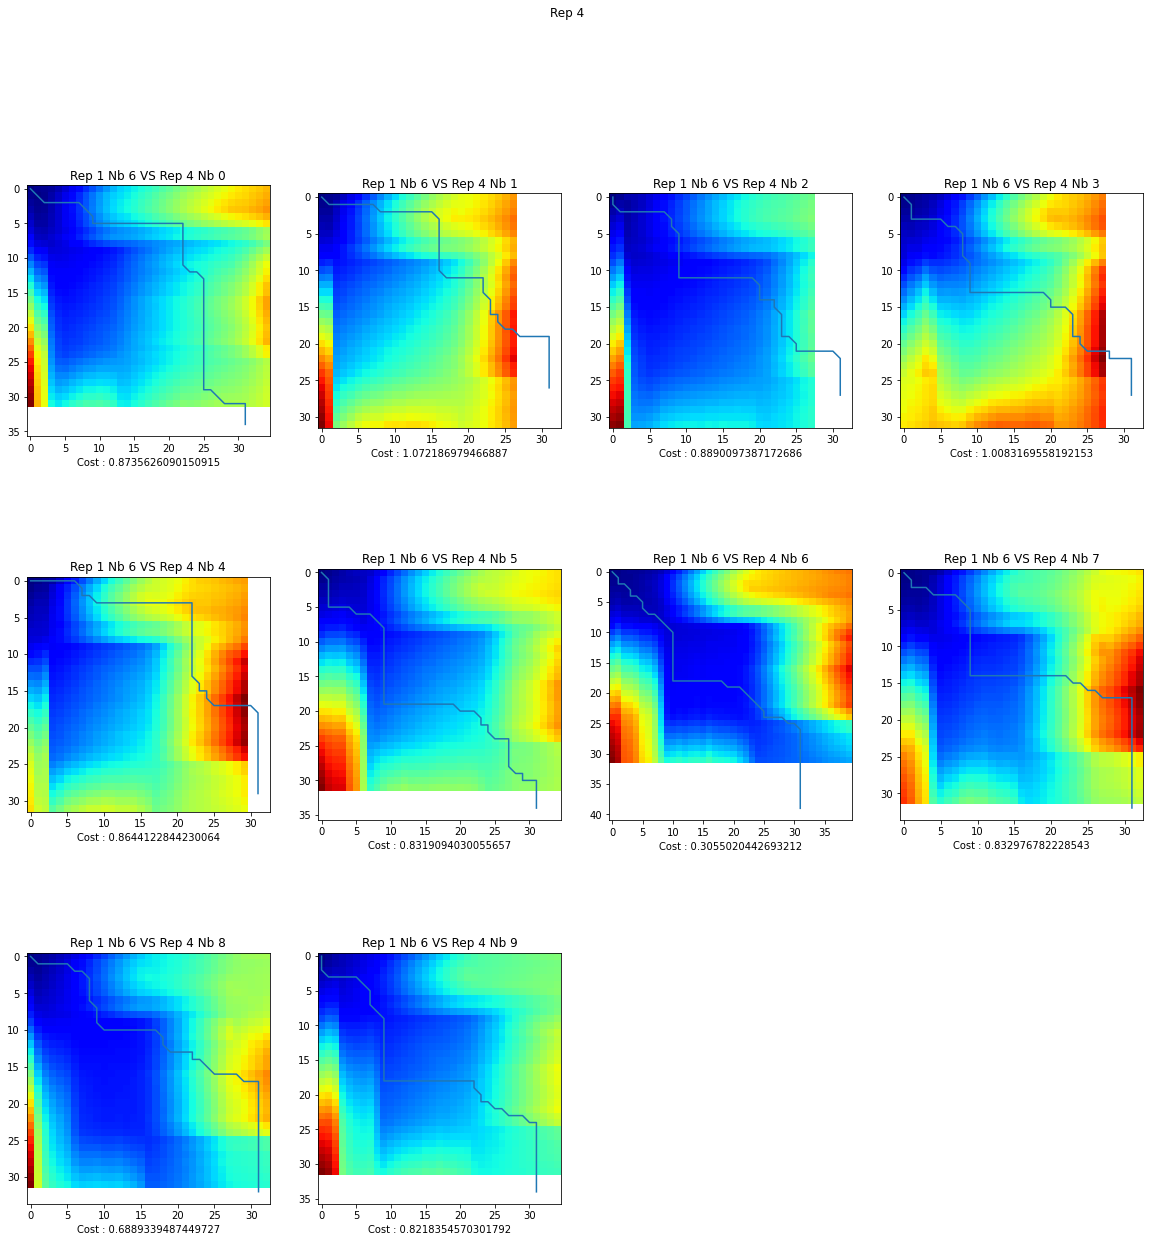

The closest distance to the reference sequence is 0.3055020442693212 achieved by the number 6


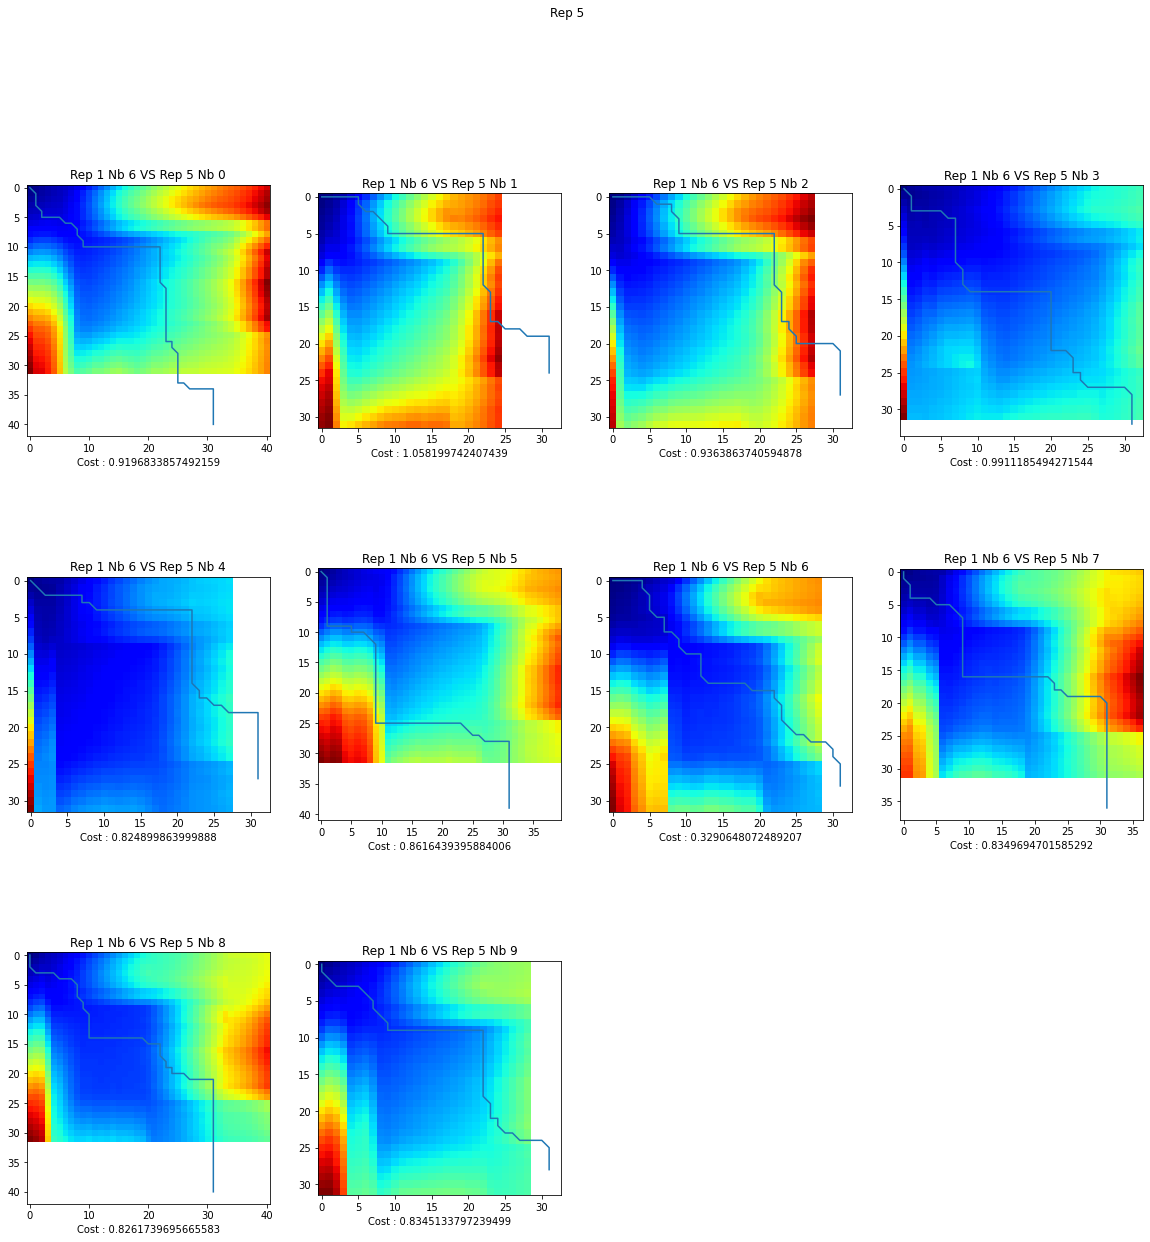

The closest distance to the reference sequence is 0.3290648072489207 achieved by the number 6


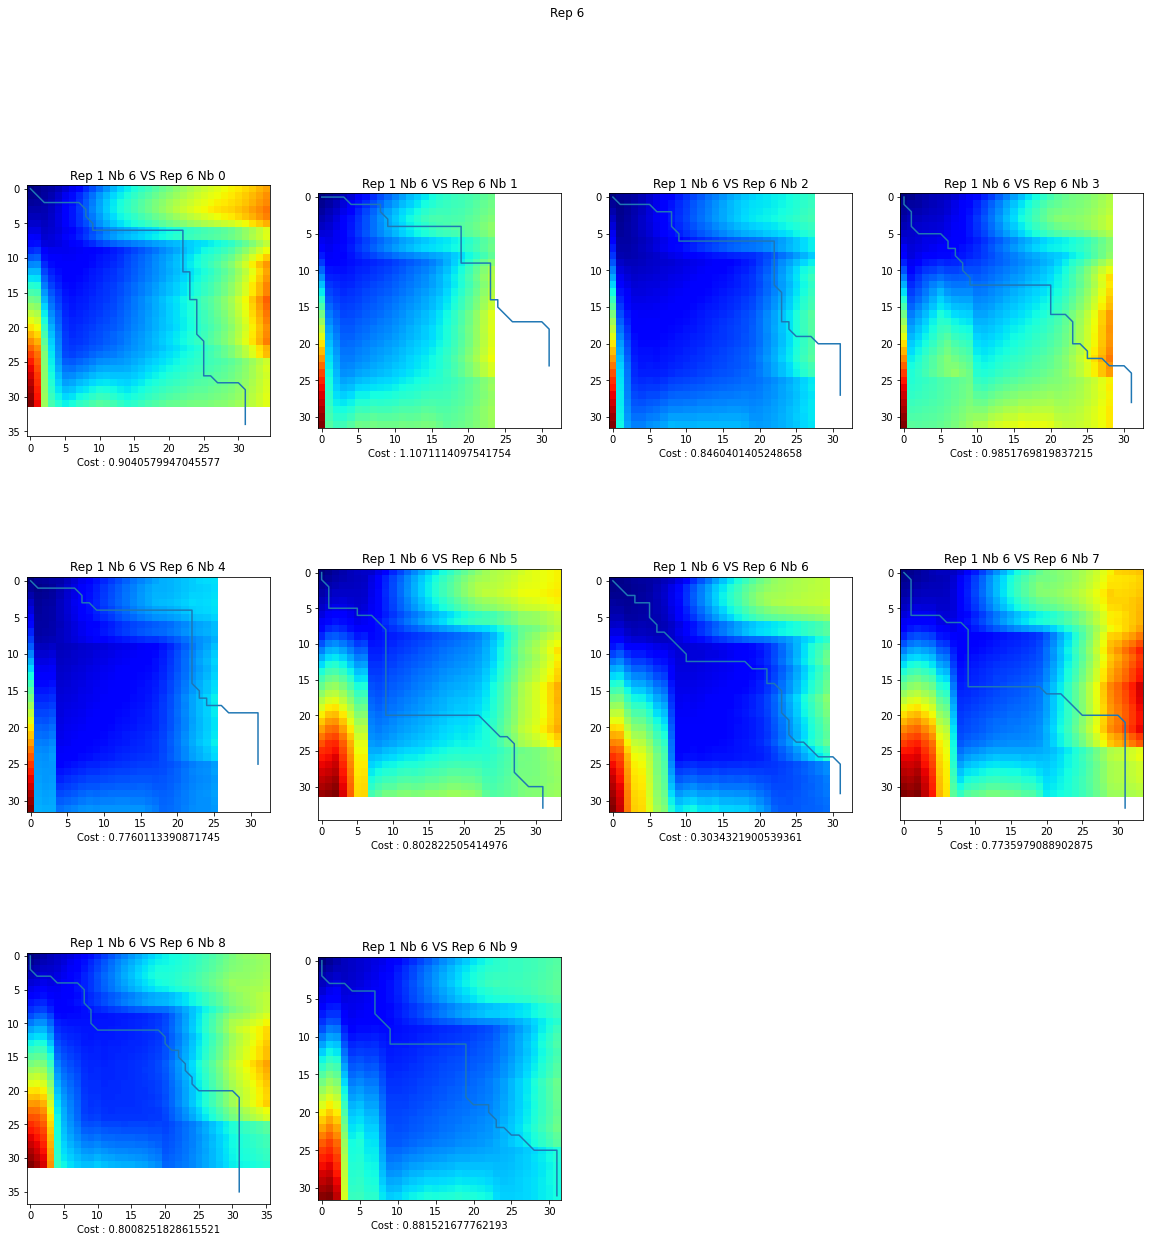

The closest distance to the reference sequence is 0.3034321900539361 achieved by the number 6


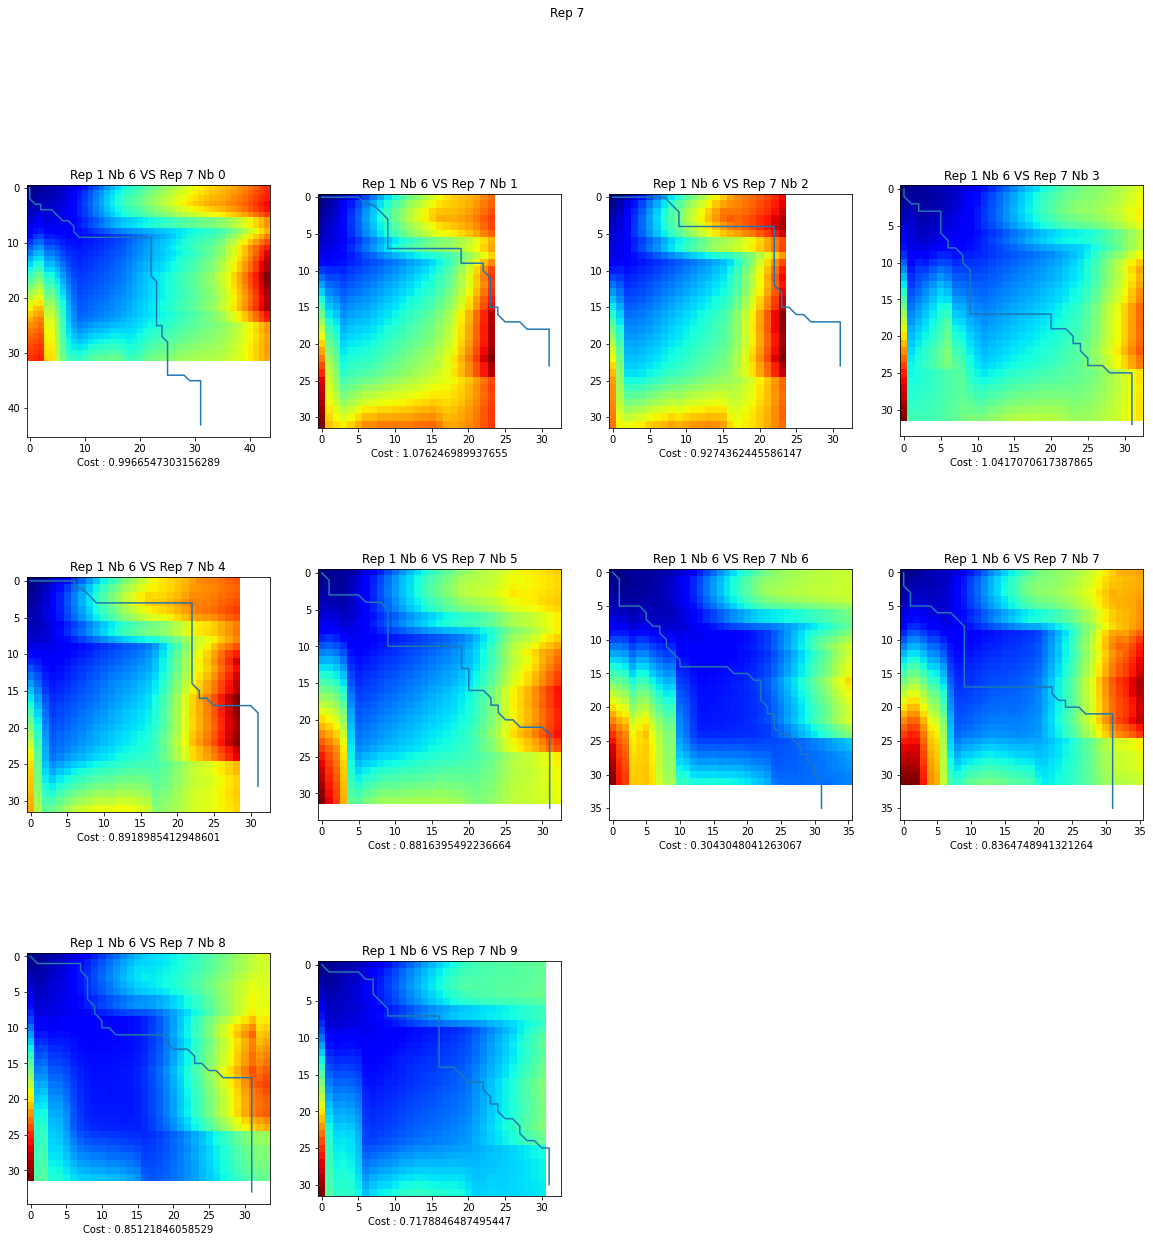

The closest distance to the reference sequence is 0.3043048041263067 achieved by the number 6


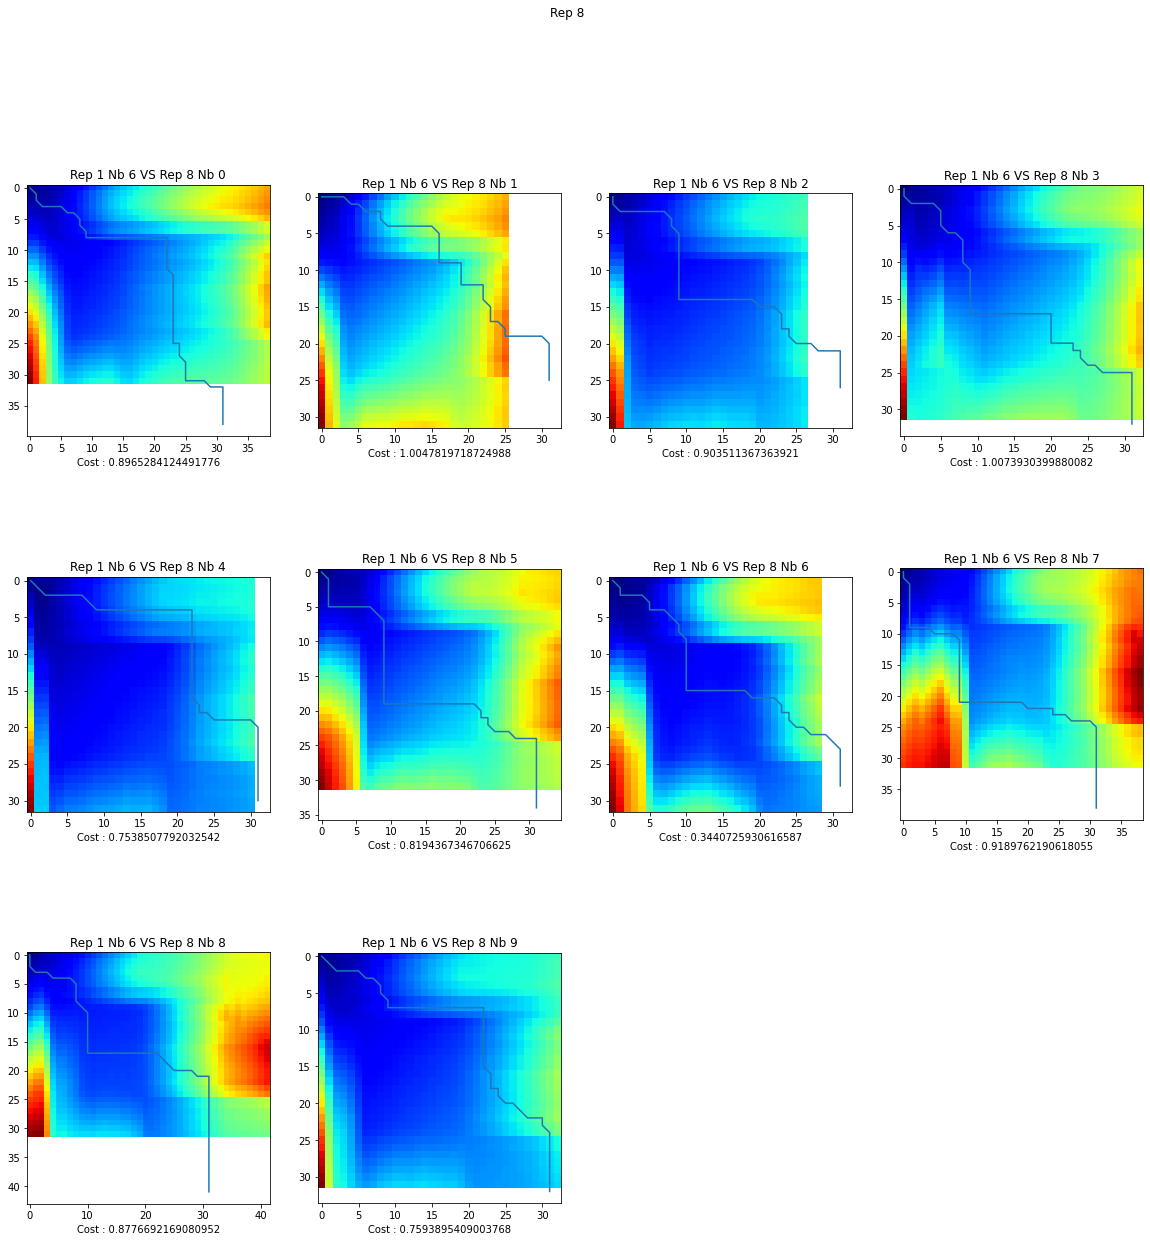

The closest distance to the reference sequence is 0.3440725930616587 achieved by the number 6


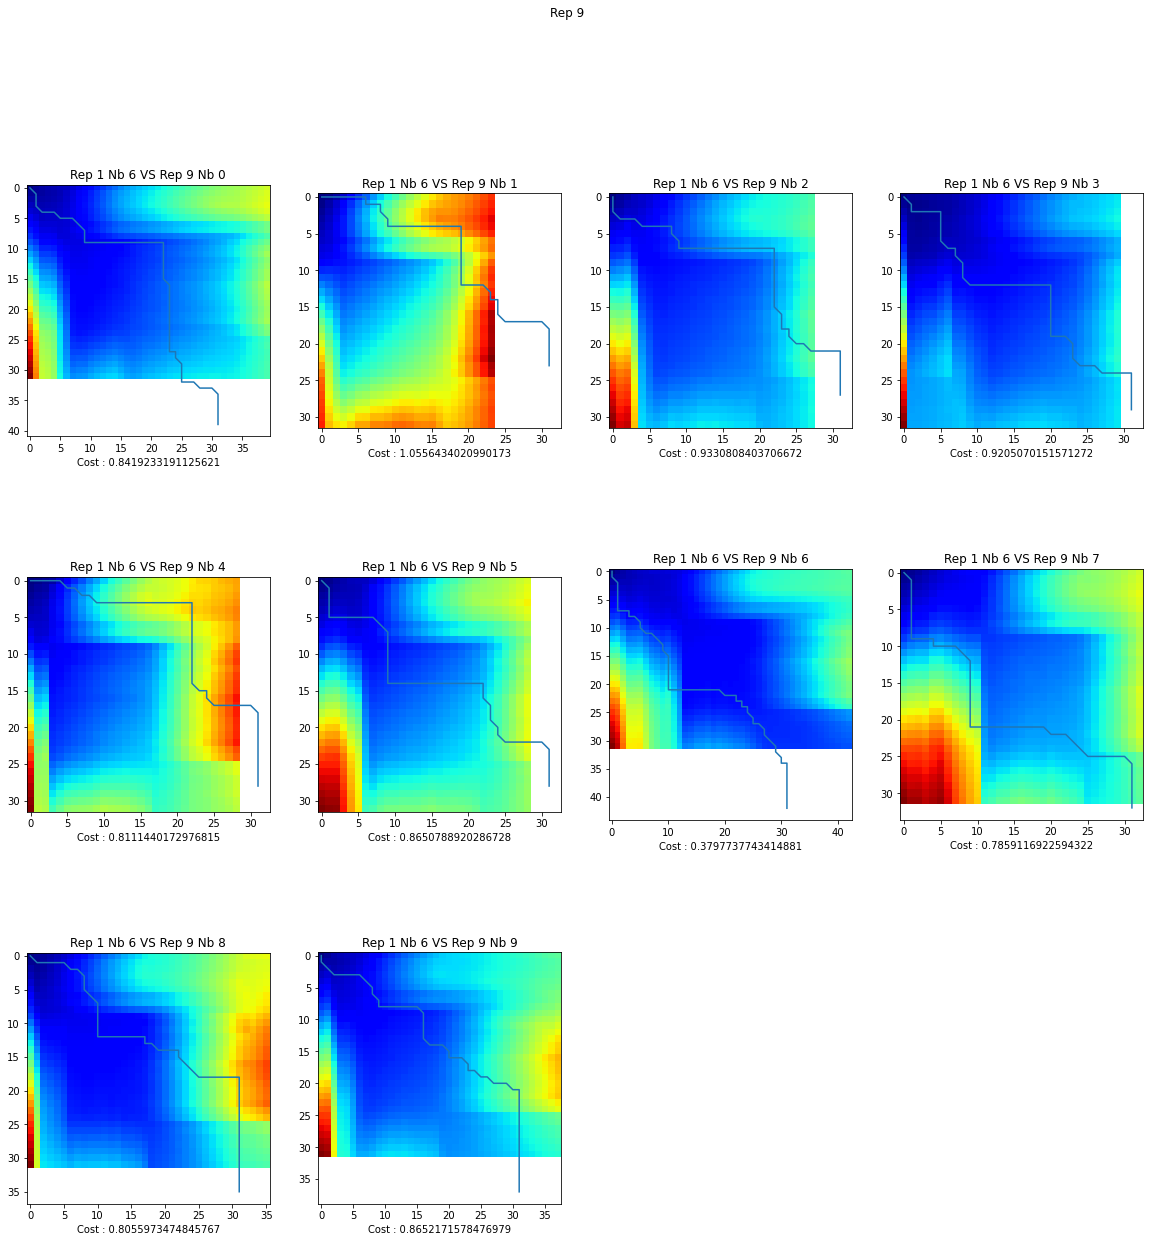

The closest distance to the reference sequence is 0.3797737743414881 achieved by the number 6


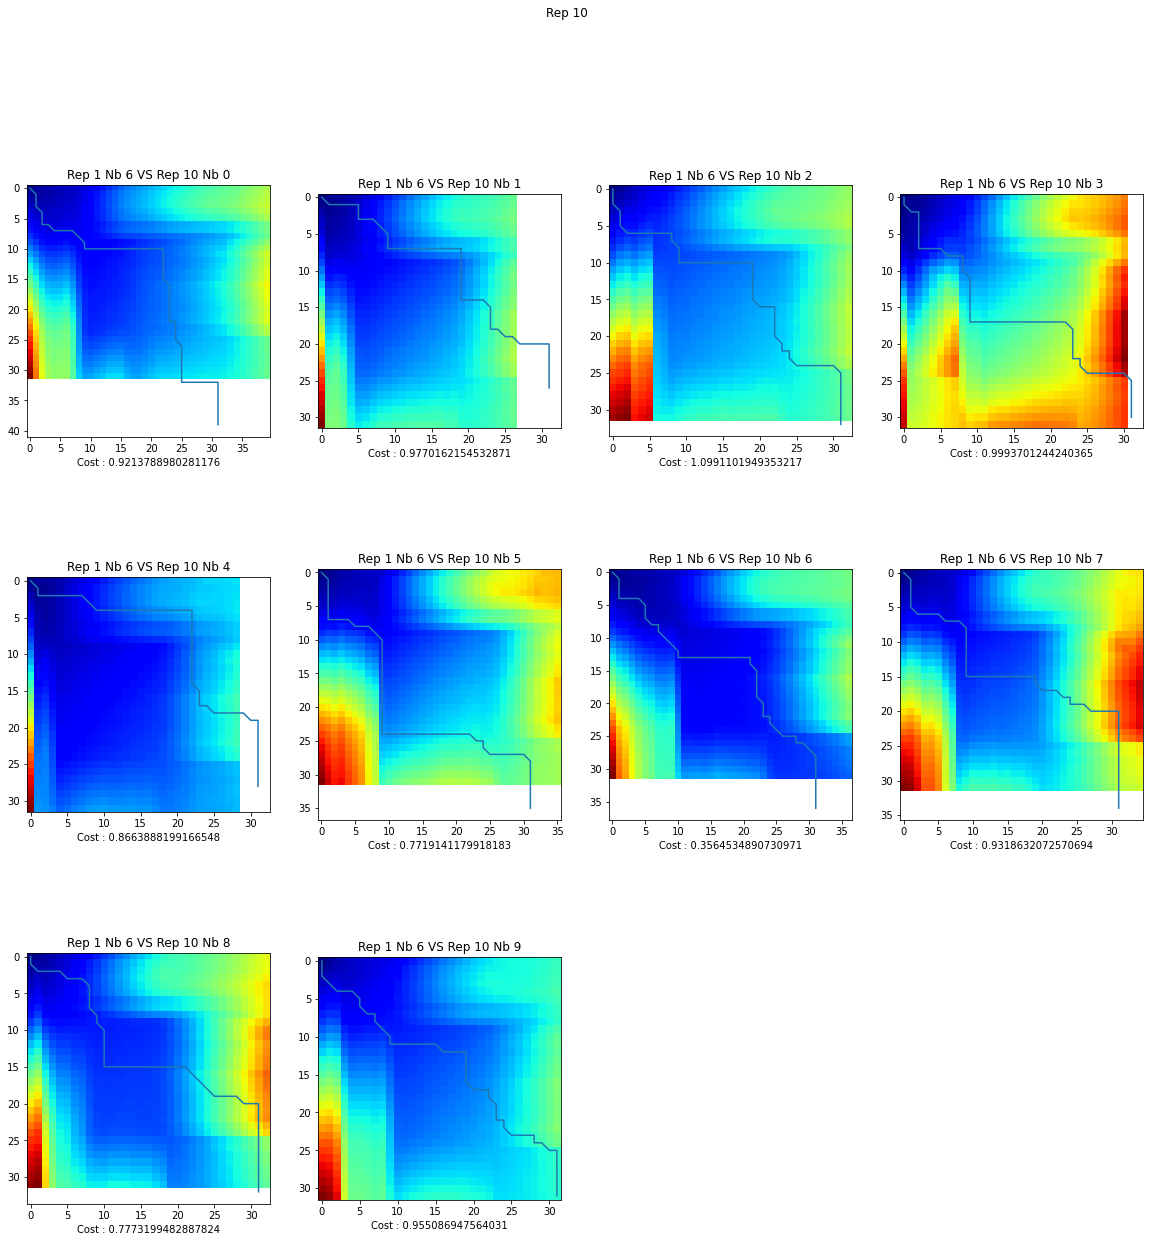

The closest distance to the reference sequence is 0.3564534890730971 achieved by the number 6


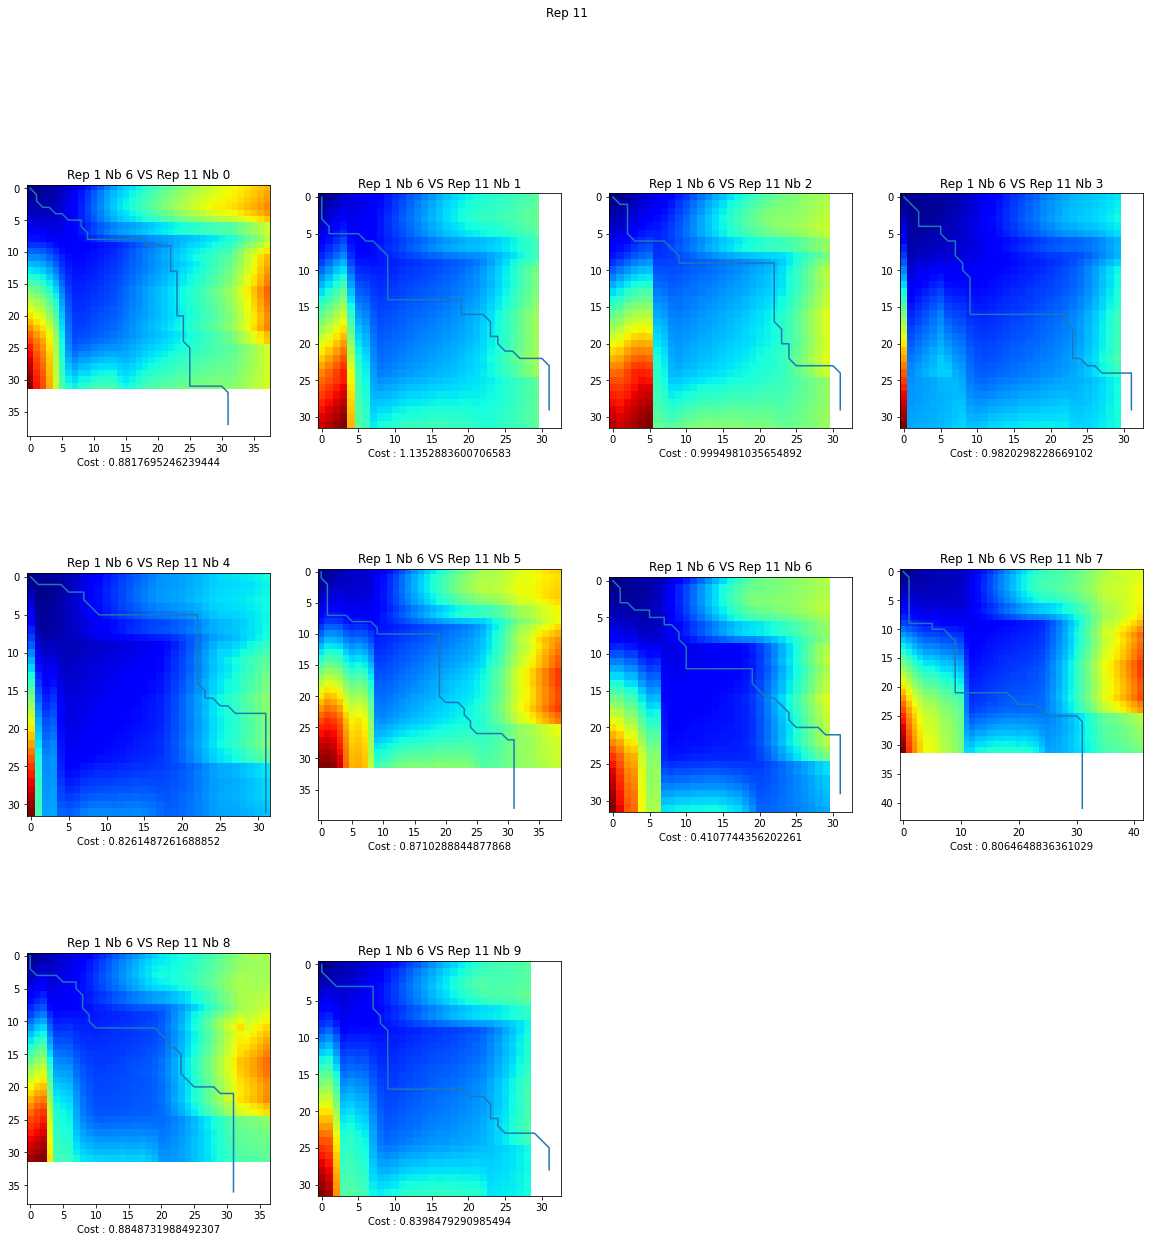

The closest distance to the reference sequence is 0.4107744356202261 achieved by the number 6


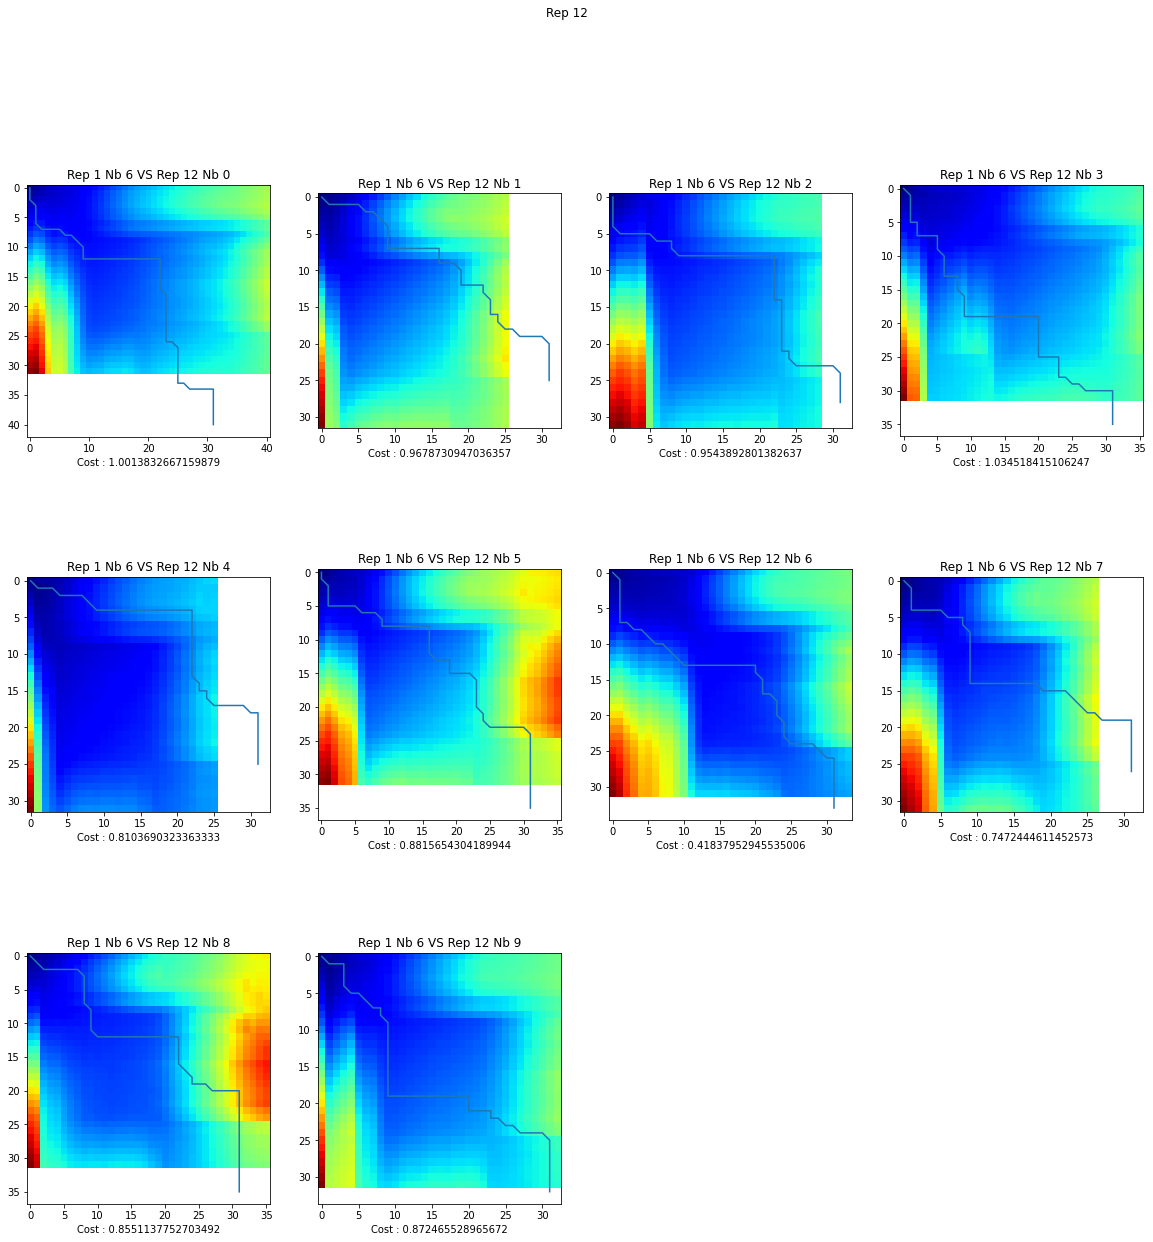

The closest distance to the reference sequence is 0.41837952945535006 achieved by the number 6


In [14]:
"""
The reference vectors will be along the y-axis
The others will be along the x-axis
"""

#Comparison with the others
for repetition in range(1,13): #Iterating
    plt.figure(figsize=(20,20))
    file_path_rep = './SIG/SIG_Rep_'+str(repetition)+'_Number_'
    name_rep = 'Rep '+str(repetition)
    distances = np.array([])
    
    for number in range(10):
        file_path_nb = file_path_rep+str(number)+'.wav'
        name_nb = name_rep+' Nb '+str(number)
        sample_rate_nb, wav_data_nb = wavfile.read(file_path_nb)
        cepstral_vectors_nb = feature_extraction(wav_data_nb, window_size, window_shift, cepstral_order)
        C_nb, M_nb, distance_nb = time_alignment(cepstral_vectors_ref, cepstral_vectors_nb, gamma=2)
        distances = np.append(distances, distance_nb)
        
        #subplot_nb = int(str(34)+str(number+1))
        plt.subplot(3, 4, number+1)
        plt.imshow(C_nb, cmap='jet')
        plt.title(name_ref+' VS '+name_nb)
        plt.plot(M_nb[:,1], M_nb[:,0])
        plt.xlabel('Cost : '+str(distance_nb))
    
    plt.suptitle(name_rep)
    plt.show()
    print('The closest distance to the reference sequence is '+str(np.amin(distances))+' achieved by the number '+str(np.argmin(distances)))

<b>Answer to 1)</b> The performances are satisfactory, the distances are around 0.3 for the correct numbers, and otherwise we are around 0.7. The algorithm manages to distinguish the different numbers.

In [15]:
"""
Let's compare Rep 1 Nb 0 with Rep 1 Nb 2, as we have seen on the last graph, the trajectory is mainly made of straight lines
Let's observe the influence of gamma on this alignment path
"""

#Global parameters
window_size = 256
window_shift = 128
cepstral_order = 10

In [16]:
#Reference:
file_path_ref = "./SIG/SIG_Rep_1_Number_0.wav"
sample_rate_ref, wav_data_ref = wavfile.read(file_path_ref)
cepstral_vectors_ref = feature_extraction(wav_data_ref, window_size, window_shift, cepstral_order)
name_ref = 'Rep 1 Nb 0'

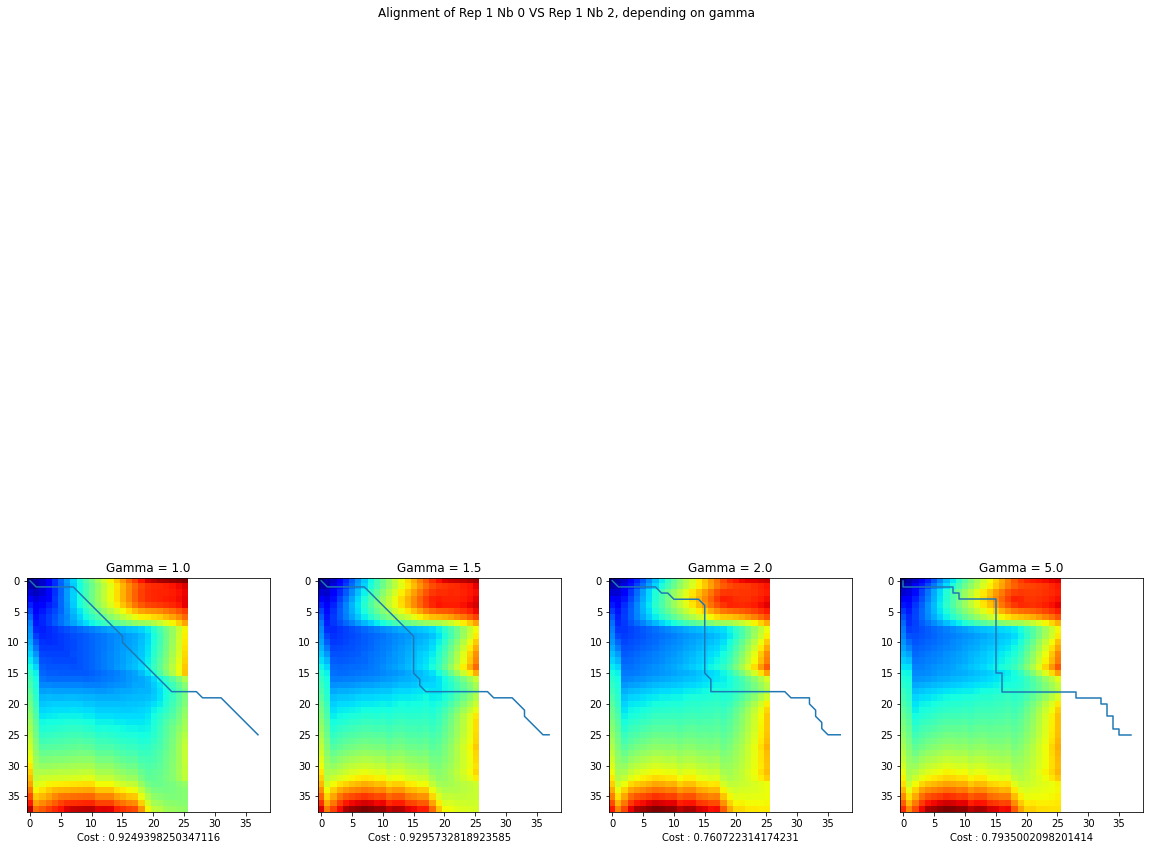

In [17]:
#Comparison
file_path_comp = "./SIG/SIG_Rep_1_Number_2.wav"
sample_rate_comp, wav_data_comp = wavfile.read(file_path_comp)
cepstral_vectors_comp = feature_extraction(wav_data_ref, window_size, window_shift, cepstral_order)
name_ref = 'Rep 1 Nb 0'

plt.figure(figsize=(20,20))
distances = np.array([])
gamma_list = np.array([1, 1.5, 2, 5])
    
for number in range(4):
    cepstral_vectors_comp = feature_extraction(wav_data_comp, window_size, window_shift, cepstral_order)
    C_comp, M_comp, distance_comp = time_alignment(cepstral_vectors_ref, cepstral_vectors_comp, gamma=gamma_list[number])
        
    plt.subplot(1, 4, number+1)
    plt.imshow(C_comp, cmap='jet')
    plt.title('Gamma = '+str(gamma_list[number]))
    plt.plot(M_comp[:,1], M_comp[:,0])
    plt.xlabel('Cost : '+str(distance_comp))
    
plt.suptitle('Alignment of Rep 1 Nb 0 VS Rep 1 Nb 2, depending on gamma')
plt.show()

<b>Answer to 2)</b> As expected, the less $\gamma$ is important, the more diagonal is the path, which is logical: the algorithm looks for the cheapest way to go.
The results are coherent: as $\gamma$ goes up, the path is more and more "squared", every little diagonal path is replaced by a down then left path.
As $\gamma$ goes down, the distances does not move that much. It goes way up when we take $\gamma=1$ because the algorithm only wants the cheapest path, regardless of the quality of it. 

Therefore, the influence of $\gamma$ on the obtained distance is limited.

<b>Answer to 3)</b> When using the Euclidian distance, we expect the cepstral vectors to represent the entire dimension from where they come from. Meaning that, the Euclidian distance would have been logical if we had not cut our cepstral vectors to 10 samples. As we can see, the same number but on different repetitions still obtain a score of 0.3, whereas we should obtain a lower value. The hypothesis does not seem that great given these results.

We should adopt a method close to the PCA used in statistics. That way, the distance would make more sense, because we would only keep the most meaningful parts of the vectors. Although we would obtain better performance on similar numbers, we are not sure the discrimination between the other numbers would be this important: those cepstral vectors are already quite far away from each other. 
Moreover, as we still keep the same intervals for the spectral vector, we can still very well discriminate when the syllables are different. The problem comes from the same number, but spaced differently: we have more trouble comparing them because we only keep the first parts, and we do not consider the other changes in speed.

## Evaluation of Speech Recognition

The goal of this part is to implement different cross-validation strategies in order to evaluate how well our method can be used for speech recognition, especially when we generalize to more than one speaker. 
We will separate the available signals into a *reference* and *unknown* set, and label all the unknow signals by finding the signal in the reference set they are the closest to (in terms of cost of the optimal path given by ```time_alignement```. We will then rotate the reference/unknown sets to perform cross-validation. 
To do so, write a function ```evaluation_recognition```.

For example, you can use the following formalism : 

```[confusion, accuracy, D] = evaluation_recognition(vectors, gamma, protocol)```

- ```vectors``` contains all the cepstral vectors for the signals in the database. It can be under the form of a list of matrices, being the outputs of ```feature_extraction``` for all signals. If $N$ if the number of repetetitions, ```vectors``` contains $10N$ matrices.
- ```gamma``` is the parameter $\gamma$ of the alignment.
- ```protocol``` is an integer value between 1 and 3 indicating the protocol to be used: each protocol corresponds to a particular way of dividing signals into training and testing sets. 

- ```confusion``` is the confusion matrix of size $10 \times 10$.
- ```accuracy``` is the recognition rate.
- ```D``` is the distance matrix between each of the elements of the database of size $10N \times 10N$, where $N$ is the number of repetitions. Note that only parts of ```D``` will be used, depending on the protocol choosed. 

The three proposed evaluation protocols are:
- **Protocol 1**: The database is randomly divided in three subsets. Two of these subsets (2/3 of repetitions) are used for the reference set and the remaining subset (1/3 of repetitions) is used for the unknown set. The procedure is repeated by rotating the unknown and reference sets.
- **Protocol 2**: A database containing only one pronunciation of each number is used as a reference database. The remaining repetitions are used for the unkown set. The procedure is repeated by rotating the unkown and reference sets. This protocol aims at evaluating the generalization capabilities of the recognition system. 
- **Protocol 3**: The first half of the database of ```SIG_MIXED``` is used as a reference database and the second half as the unkown database. The procedure is repeated by inversing the role of the two sets. This protocol aims at evaluating the generalization capabilities on a database containing data from the two speakers. Careful: since the goal here is to understand if you can use examples from one person to recognize numbers pronounced by a different person, you have to not shuffle the examples !

In [18]:
"""
    cepstral_all[i][0] gives the cepstral vectors
    cepstral_all[i][1] gives the number that is said in the audio
    cepstral_all[i][2] gives the index of the cepstral vectors in the cepstral_all list of matrices
"""

#Let's create the matrix of cepstral vectors ##SIG dataset ONLY
cepstral_all_SIG = []

i_total_nb = 0
for repetition in range(1,13): #Iterating
    file_path_rep = './SIG/SIG_Rep_'+str(repetition)+'_Number_'
    name_rep = 'Rep '+str(repetition)
    
    for number in range(10):
        file_path_nb = file_path_rep+str(number)+'.wav'
        name_nb = name_rep+' Nb '+str(number)
        sample_rate_nb, wav_data_nb = wavfile.read(file_path_nb)
        cepstral_vectors_nb = feature_extraction(wav_data_nb, window_size, window_shift, cepstral_order)
        cepstral_inter = []
        cepstral_inter.append(cepstral_vectors_nb)
        cepstral_inter.append(number) #This is the "y" part of the dataset, so that we can compute an accuracy
        cepstral_inter.append(i_total_nb) #This is the index in the final matrix, so that we can compute D
        cepstral_all_SIG.append(cepstral_inter) #Adding the result to the list of matrices
        i_total_nb += 1

In [19]:
cepstral_all_SIG2 = []

i_total_nb = 0
for repetition in range(1,7): #Iterating
    file_path_rep = './SIG2/SIG2_Rep_'+str(repetition)+'_Number_'
    name_rep = 'Rep '+str(repetition)
    
    for number in range(10):
        file_path_nb = file_path_rep+str(number)+'.wav'
        name_nb = name_rep+' Nb '+str(number)
        sample_rate_nb, wav_data_nb = wavfile.read(file_path_nb)
        cepstral_vectors_nb = feature_extraction(wav_data_nb, window_size, window_shift, cepstral_order)
        cepstral_inter = []
        cepstral_inter.append(cepstral_vectors_nb)
        cepstral_inter.append(number) #This is the "y" part of the dataset, so that we can compute an accuracy
        cepstral_inter.append(i_total_nb) #This is the index in the final matrix, so that we can compute D
        cepstral_all_SIG2.append(cepstral_inter) #Adding the result to the list of matrices
        i_total_nb += 1

In [20]:
cepstral_all_SIGMIX = []

i_total_nb = 0
for repetition in range(1,13): #Iterating
    file_path_rep = './SIGMIX/SIGMIX_Rep_'+str(repetition)+'_Number_'
    name_rep = 'Rep '+str(repetition)
    
    for number in range(10):
        file_path_nb = file_path_rep+str(number)+'.wav'
        name_nb = name_rep+' Nb '+str(number)
        sample_rate_nb, wav_data_nb = wavfile.read(file_path_nb)
        cepstral_vectors_nb = feature_extraction(wav_data_nb, window_size, window_shift, cepstral_order)
        cepstral_inter = []
        cepstral_inter.append(cepstral_vectors_nb)
        cepstral_inter.append(number) #This is the "y" part of the dataset, so that we can compute an accuracy
        cepstral_inter.append(i_total_nb) #This is the index in the final matrix, so that we can compute D
        cepstral_all_SIGMIX.append(cepstral_inter) #Adding the result to the list of matrices
        i_total_nb += 1

In [25]:
def evaluation_recognition(vectors, gamma, protocol=1):
    confusion = np.zeros((10, 10))
    accuracy = 0
    length = len(vectors)
    N = length//10
    D = np.zeros((10*N, 10*N))
    
    """
        Protocol 1: Dataset split in 2/3 and 1/3
    """
    if(protocol==1):
        #Construction of the datasets
        list_of_indices = np.arange(length)
        np.random.shuffle(list_of_indices)                     #List of indices shuffled (we're not shuffling directly
                                                               #vectors because too difficult with our structure of Python list)
        #print('list of indices = '+str(list_of_indices))
        subset_delim = int((2/3)*length)
        #print('Subset_delim = '+str(subset_delim))
        reference_ids = list_of_indices[:subset_delim]
        unknown_ids = list_of_indices[subset_delim:]
        reference_set = []
        unknown_set = []

        for ids in reference_ids:
            reference_set.append(vectors[ids])
        for ids in unknown_ids:
            unknown_set.append(vectors[ids])

        length_ref = len(reference_set)
        length_unk = len(unknown_set)
    
    """
        Protocol 2: Dataset split according to the repetition type
    """
    if(protocol==2):
        #Construction of the datasets
        list_of_indices = np.arange(length)
        random_rep = np.random.randint(N)
        reference_ids = list_of_indices[random_rep*10:(random_rep*10)+10]
        if(random_rep==0):
            unknown_ids = list_of_indices[10:]
        elif(random_rep==(N-1)):
            unknown_ids = list_of_indices[:random_rep*10]
        else:
            unknown_ids = np.append(list_of_indices[:random_rep*10], list_of_indices[(random_rep+1)*10:])
        reference_set = []
        unknown_set = []

        for ids in reference_ids:
            reference_set.append(vectors[ids])
        for ids in unknown_ids:
            unknown_set.append(vectors[ids])

        length_ref = len(reference_set)
        length_unk = len(unknown_set)
        
    """
        Protocol 3: Dataset split in two (SIGMIX)
    """
    if(protocol==3):
        #Construction of the datasets
        list_of_indices = np.arange(length)
        reference_ids = list_of_indices[:length//2]
        unknown_ids = list_of_indices[length//2:]
        
        reference_set = []
        unknown_set = []

        for ids in reference_ids:
            reference_set.append(vectors[ids])
        for ids in unknown_ids:
            unknown_set.append(vectors[ids])

        length_ref = len(reference_set)
        length_unk = len(unknown_set)
        
    """
        Protocol 4: Dataset split in two (SIGMIX, rotation)
    """
    if(protocol==4):
        #Construction of the datasets
        list_of_indices = np.arange(length)
        reference_ids = list_of_indices[length//2:]
        unknown_ids = list_of_indices[:length//2]
        
        reference_set = []
        unknown_set = []

        for ids in reference_ids:
            reference_set.append(vectors[ids])
        for ids in unknown_ids:
            unknown_set.append(vectors[ids])

        length_ref = len(reference_set)
        length_unk = len(unknown_set)
        
    """
        General algorithm
    """
    for k in range(length_unk): #Iteration over the UNKNOWN (TO GUESS)
        the_unknown = unknown_set[k]
        distances = np.zeros(length_ref)

        for l in range(length_ref): #Iteration over the REFERENCES (TO COMPARE)
            the_reference = reference_set[l]
            C, M, distance = time_alignment(the_unknown[0], the_reference[0], gamma=gamma)

            distances[l] = distance #We stock the different distances to argmin afterwards
            D[the_unknown[2], the_reference[2]] = distance #Updating the distance in D

        #print('Distances: '+str(distances))
        best_fit = np.argmin(distances)
        nb_unk = the_unknown[1]
        nb_best_fit = reference_set[best_fit][1]
        confusion[nb_unk, nb_best_fit] = 1
        if(nb_unk==nb_best_fit): #It's a match!
            accuracy += 1

    accuracy = accuracy/length_unk
    confusion = confusion/length_unk
    
    return confusion, accuracy, D

In [26]:
def plot_confusion(confusion_map, annot_title):
    ax = sns.heatmap(confusion_map, annot=True, cmap='Blues')

    ax.set_title('Confusion Matrix '+annot_title+'\n\n');
    ax.set_xlabel('\nPredicted Number')
    ax.set_ylabel('Actual Number');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(np.arange(10))
    ax.yaxis.set_ticklabels(np.arange(10))

    ## Display the visualization of the Confusion Matrix.
    plt.show()

## Protocol 1

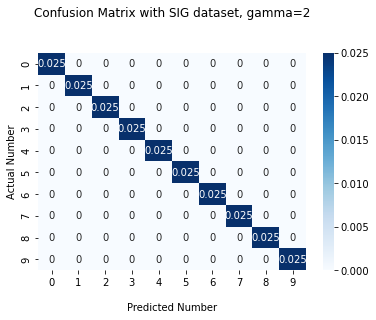

Accuracy for SIG dataset with gamma=2 = 1.0


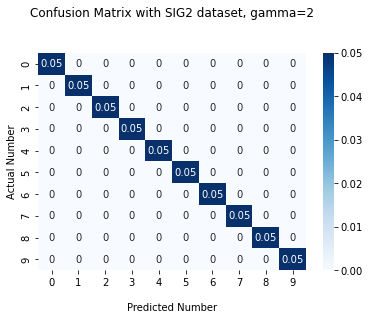

Accuracy for SIG2 dataset with gamma=2 = 1.0


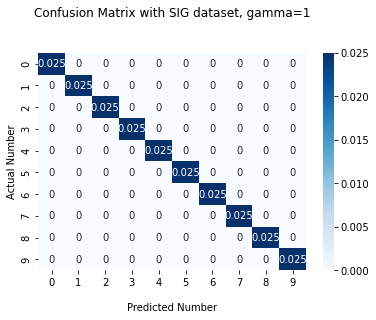

Accuracy for SIG dataset with gamma=1 = 1.0


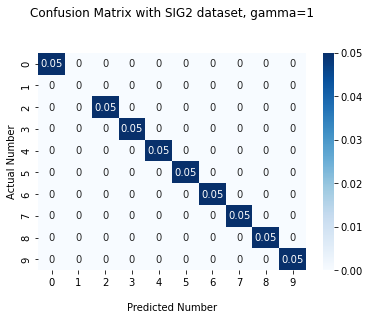

Accuracy for SIG2 dataset with gamma=1 = 1.0


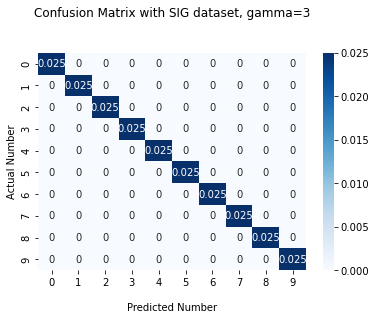

Accuracy for SIG dataset with gamma=3 = 1.0


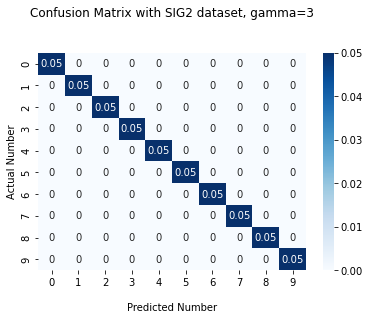

Accuracy for SIG2 dataset with gamma=3 = 1.0


In [33]:
results_accuracy_SIG = np.zeros(5)
results_accuracy_SIG2 = np.zeros(5)
for k in range(5):
    confusion_SIG_1, accuracy_SIG_1, D_SIG_1 = evaluation_recognition(cepstral_all_SIG, 2, protocol=1)
    confusion_SIG2_1, accuracy_SIG2_1, D_SIG2_1 = evaluation_recognition(cepstral_all_SIG2, 2, protocol=1)
    results_accuracy_SIG[k] = accuracy_SIG_1
    results_accuracy_SIG2[k] = accuracy_SIG2_1

plot_confusion(confusion_SIG_1, 'with SIG dataset, gamma=2')
print('Accuracy for SIG dataset with gamma=2 = '+str(np.mean(results_accuracy_SIG)))

plot_confusion(confusion_SIG2_1, 'with SIG2 dataset, gamma=2')
print('Accuracy for SIG2 dataset with gamma=2 = '+str(np.mean(results_accuracy_SIG2)))

for k in range(5):
    confusion_SIG_1, accuracy_SIG_1, D_SIG_1 = evaluation_recognition(cepstral_all_SIG, 1, protocol=1)
    confusion_SIG2_1, accuracy_SIG2_1, D_SIG2_1 = evaluation_recognition(cepstral_all_SIG2, 1, protocol=1)
    results_accuracy_SIG[k] = accuracy_SIG_1
    results_accuracy_SIG2[k] = accuracy_SIG2_1
    
plot_confusion(confusion_SIG_1, 'with SIG dataset, gamma=1')
print('Accuracy for SIG dataset with gamma=1 = '+str(np.mean(results_accuracy_SIG)))

plot_confusion(confusion_SIG2_1, 'with SIG2 dataset, gamma=1')
print('Accuracy for SIG2 dataset with gamma=1 = '+str(np.mean(results_accuracy_SIG2)))
    
for k in range(5):
    confusion_SIG_1, accuracy_SIG_1, D_SIG_1 = evaluation_recognition(cepstral_all_SIG, 3, protocol=1)
    confusion_SIG2_1, accuracy_SIG2_1, D_SIG2_1 = evaluation_recognition(cepstral_all_SIG2, 3, protocol=1)
    results_accuracy_SIG[k] = accuracy_SIG_1
    results_accuracy_SIG2[k] = accuracy_SIG2_1
    
plot_confusion(confusion_SIG_1, 'with SIG dataset, gamma=3')
print('Accuracy for SIG dataset with gamma=3 = '+str(np.mean(results_accuracy_SIG)))

plot_confusion(confusion_SIG2_1, 'with SIG2 dataset, gamma=3')
print('Accuracy for SIG2 dataset with gamma=3 = '+str(np.mean(results_accuracy_SIG2)))

## Protocol 2

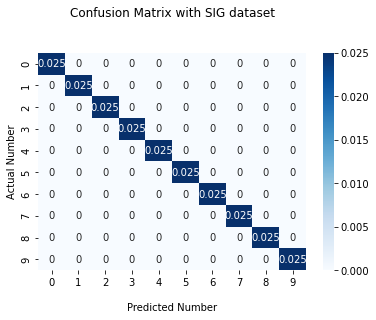

Accuracy for SIG dataset = 0.9745454545454546


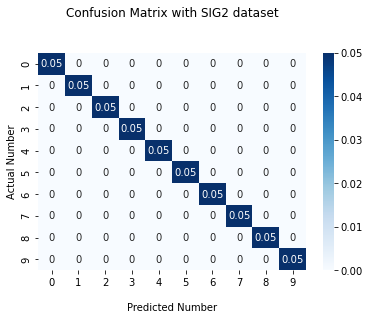

Accuracy for SIG2 dataset = 0.9879999999999999


In [34]:
results_accuracy_SIG = np.zeros(5)
results_accuracy_SIG2 = np.zeros(5)
for k in range(5):
    confusion_SIG_2, accuracy_SIG_2, D_SIG_2 = evaluation_recognition(cepstral_all_SIG, 2, protocol=2)
    confusion_SIG2_2, accuracy_SIG2_2, D_SIG2_2 = evaluation_recognition(cepstral_all_SIG2, 2, protocol=2)
    results_accuracy_SIG[k] = accuracy_SIG_2
    results_accuracy_SIG2[k] = accuracy_SIG2_2

plot_confusion(confusion_SIG_1, 'with SIG dataset')
print('Accuracy for SIG dataset = '+str(np.mean(results_accuracy_SIG)))

plot_confusion(confusion_SIG2_1, 'with SIG2 dataset')
print('Accuracy for SIG2 dataset = '+str(np.mean(results_accuracy_SIG2)))

## Protocol 3

In [35]:
confusion_SIGMIX_3, accuracy_SIGMIX_3, D_SIGMIX_3 = evaluation_recognition(cepstral_all_SIGMIX, 2, protocol=3)
confusion_SIGMIX_4, accuracy_SIGMIX_4, D_SIGMIX_4 = evaluation_recognition(cepstral_all_SIGMIX, 2, protocol=4)

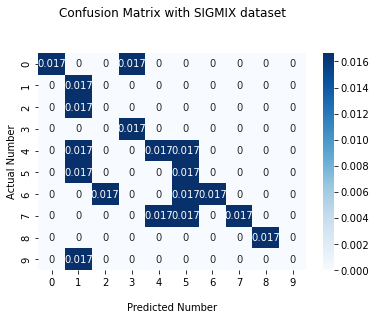

Accuracy for SIGMIX dataset = 0.5666666666666667


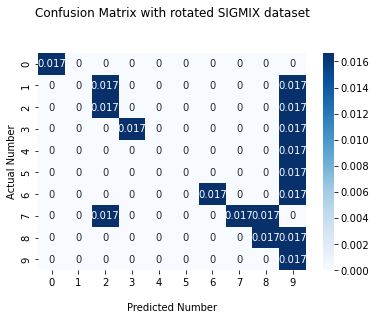

Accuracy for rotated SIGMIX dataset = 0.45


In [36]:
plot_confusion(confusion_SIGMIX_3, 'with SIGMIX dataset')
print('Accuracy for SIGMIX dataset = '+str(accuracy_SIGMIX_3))

plot_confusion(confusion_SIGMIX_4, 'with rotated SIGMIX dataset')
print('Accuracy for rotated SIGMIX dataset = '+str(accuracy_SIGMIX_4))

Questions: 
- Evaluate the speech recognition performance with protocol 1 on the data ```SIG```, and then on the data ```SIG2```. What are the confusions ? What value of $\gamma$ parameter offers the best results ?
- Evaluate the generalization capabilities using protocol 2 on the data ```SIG```, and then on the data ```SIG2```. What do you notice?
- Evaluate the generalization capabilities to other speakers using protocol 3 on ```SIG_MIXED```. Explain the results.
- What are the limitations of dynamic time warping approaches for speech recognition that you have identified during this lab ? Propose possible solutions to these problems.

#### For protocol 1
Our algorithm works really well on both datasets. There are no confusions. We have already seen that the impact of $\gamma$ on distance is limited, and it is confirmed here, as different values of $\gamma$ do not change our results (we have kept reasonable values of gamma though).

#### For protocol 2
Our algorithm still works great on both datasets. Meaning that it is good at generalizing repetitions for a **single** user.

#### For protocol 3
We achieve around 50% of accuracy, which is the worst case possible, the algorithm does not manage to identify the numbers at all. Therefore, our algorithm is not able to distinguish between two different speakers (we have split the dataset so that the repetitions from both speakers do not mix).

#### Limitations
As we have seen with our algorithm, DTW is a great way to do speech recognition only if we have **one speaker**. If we do not give our program samples from multiple users (as seen in protocol 3), the algorithm fails to recognize the numbers, therefore it lacks generalization on multiple users.
A possible solution would be to implement deep learning networks, as to be able to generalize all the more to multiple users (CNNs for feature recognition for example), and why not do data augmentation, pitch modification so that we can cover as much people as possible with a limited number of given samples at the start.

$$ \% $$